# Download and visualize your Twitter network

Following the example at [How to download and visualize your Twitter network](https://towardsdatascience.com/how-to-download-and-visualize-your-twitter-network-f009dbbf107b), by Steve Hedden

In [1]:
import tweepy
import pandas as pd

In [2]:
# Twitter API credentials

consumer_key = 'eJykYYpESCDH3iC4BAibiExEl'
consumer_secret = 'hxHOAD2C1bIeKFQWBfFCYBNt4JlTdY5Oz0H3gVbwh78HPI5qy8'
access_token = '19862042-asa4mxiOVig5Xh50KdPDfpJvlEH6zOrDgckQ3AKlb'
access_token_secret = 'BVArwJYuznzozEzeTCFJVYA7ISwykQyN8pWqaVNnFLipk'

In [3]:
# The following code just uses the credentials entered above to connect to the API. 

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)
# wait_on_rate_limit_notify=True, compression=True seems to be deprecated

In [4]:
# Get my ID

me = api.get_user(screen_name = 'peterbjordan')
me.id

19862042

In [5]:
# The following code creates a list of my followers

user_list = ["19862042"]
follower_list = []
for user in user_list:
    followers = []
    try:
        for page in tweepy.Cursor(api.get_follower_ids, user_id=user).pages():
            followers.extend(page)
            print(len(followers))
    except tweepy.errors.TweepyException:
        print("error")
        continue
    follower_list.append(followers)


1265


In [6]:
df = pd.DataFrame(columns=['source','target']) #Empty DataFrame
df['target'] = follower_list[0] #Set the list of followers as the target column
df['source'] = 19862042 #Set my user ID as the source 
df

,source,target
0,19862042,1594654204391526401
1,19862042,1299475743169155072
2,19862042,2715353151
3,19862042,2461924214
4,19862042,1546247048978173963
...,...,...
1260,19862042,744713
1261,19862042,7905122
1262,19862042,19068604
1263,19862042,12177772


To visualize this simple network, we can use the NetworkX package to convert the DataFrame into a graph or network.

In [7]:
import networkx as nx
G = nx.from_pandas_edgelist(df, 'source', 'target') #Turn df into graph
pos = nx.spring_layout(G) #specify layout for visual

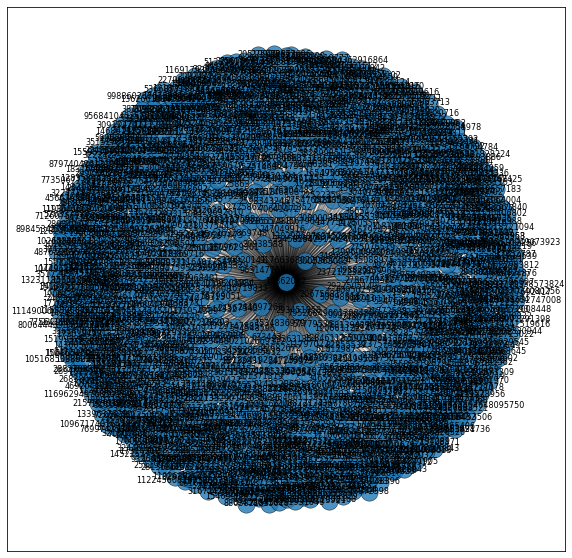

In [8]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=8)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)

Wow that is dense, but just shows links to me. What we really want is to get all of the followers of my 1264 followers.

user_list = list(df['target']) #Use the list of followers we extracted in the code above i.e. my 1264 followers

for user_id in user_list:
    print(user_id)
    followers = []
    follower_list = []

    # fetching the user
    #user = api.get_user(userID)
    #user = api.get_user(user_id)
    user = api.get_user
   

    # fetching the followers_count
    #followers_count = user.followers_count
    followers_count = api.get_followers

    try:
        for page in tweepy.Cursor(api.get_follower_ids, user_id=user_id).pages():
            followers.extend(page)
            print(len(followers))
            
            if followers_count() == 5000:
            #if followers_count() >= 5000: #Only take first 5000 followers    
                break
                
    except tweepy.errors.TweepyException:
        print("error")
        continue
    follower_list.append(followers)
    temp = pd.DataFrame(columns=['source', 'target'])
    temp['target'] = follower_list[0]
    temp['source'] = user_id
    df = df.append(temp)
    df.to_csv("networkOfFollowers.csv")
    

In [9]:
df = pd.read_csv("networkOfFollowers.csv", low_memory=False) #Read into a df


In [10]:
df.tail()

,Unnamed: 0,source,target
1978406,381,93490124,330375824
1978407,382,93490124,14169364
1978408,383,93490124,309835197
1978409,384,93490124,39960478
1978410,385,93490124,258091615


In [11]:
G = nx.from_pandas_edgelist(df, 'source', 'target')

In [12]:
G.number_of_nodes() #Find the total number of nodes in this graph

1485303

In [13]:
G_sorted = pd.DataFrame(sorted(G.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['nconst','degree']
G_sorted.head()

,nconst,degree
0,105305259,334226
1,55434962,138746
2,19181549,129731
3,44849238,125632
4,17442320,75090


In [14]:
u = api.get_user(user_id = 1255845086811828224)
u.screen_name

'GrimArtGroup'

In [15]:
G_tmp = nx.k_core(G, 10) #Exclude nodes with degree less than 10

With this smaller graph we can easily do some network analytics. We start by splitting the graph into groups using a community detection algorithm.

In [16]:
import community as community_louvain

#from community import community_louvain
partition = community_louvain.best_partition(G_tmp)
#Turn partition into dataframe
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['names','group']

We need to run the degree centrality code again now that our network is smaller.

In [17]:
G_sorted = pd.DataFrame(sorted(G_tmp.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['names','degree']
G_sorted.head()
dc = G_sorted

Now that we have the nodes split into groups and the degree of each node, we combine these into one DataFrame.

In [18]:
combined = pd.merge(dc,partition1, how='left', left_on="names",right_on="names")

Now we can visualize this graph using the following code.

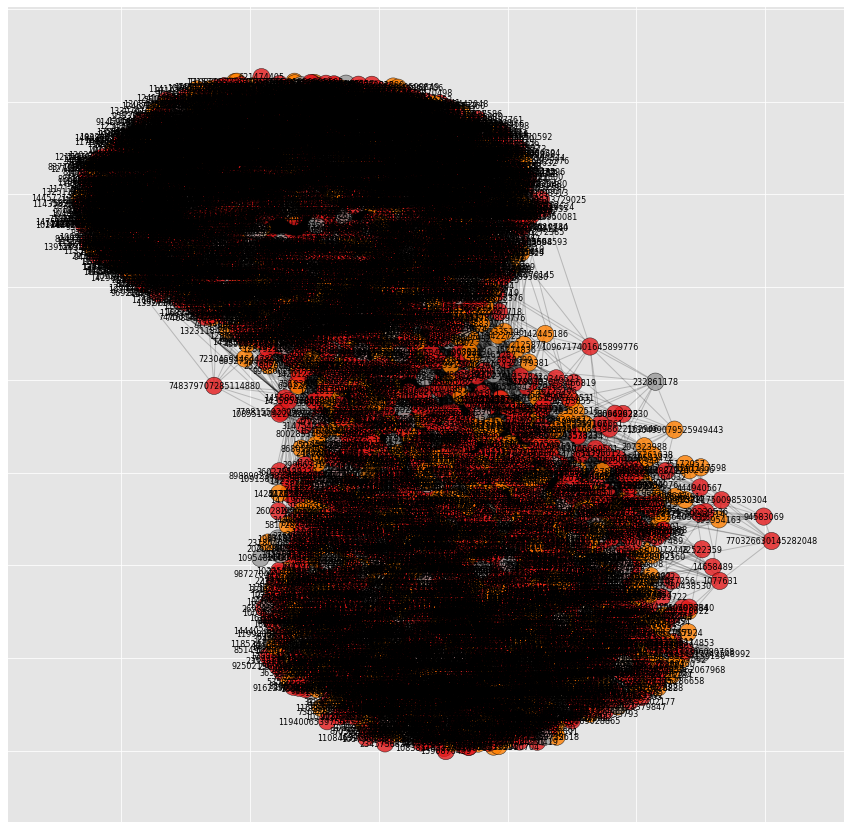

In [19]:
pos = nx.spring_layout(G_tmp)
f, ax = plt.subplots(figsize=(15, 15))
plt.style.use('ggplot')
#cc = nx.betweenness_centrality(G2)
nodes = nx.draw_networkx_nodes(G_tmp, pos,
                               cmap=plt.cm.Set1,
                               node_color=combined['group'],
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G_tmp, pos, font_size=8)
nx.draw_networkx_edges(G_tmp, pos, width=1.0, alpha=0.2)
plt.savefig('twitterFollowers.png')

Steve says:

"What a mess. I’m sure there are ways to make that visual look better using matplotlib, but at this point, I always just export the files to csv format and use Gephi to visualize. Gephi is an open-source network analysis and visualization software. You should be able to easily install it for free from their website. It’s pretty easy to get started and allows for some really beautiful visualizations. If you have never used Gephi, here is a good tutorial to get started from 
Luca Hammer: [Guide: Analyzing Twitter Networks with Gephi 0.9.1](https://medium.com/@Luca/guide-analyzing-twitter-networks-with-gephi-0-9-1-2e0220d9097d).

To use Gephi, first you need to export the node list and the edge list as csv files."

In [20]:
combined = combined.rename(columns={"names": "Id"}) #I've found Gephi really likes when your node column is called 'Id'
edges = nx.to_pandas_edgelist(G_tmp)
nodes = combined['Id']
edges.to_csv("edges.csv")
combined.to_csv("nodes.csv")